In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import itertools
import nltk
from nltk.corpus import stopwords
import regex as re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [ ]:
!wget https://drive.upm.es/index.php/s/LkFtKeCdq9ElQZX/download -O OkCupid.zip
!unzip -o OkCupid.zip
!rm OkCupid.zip

--2021-06-25 11:04:13--  https://drive.upm.es/index.php/s/LkFtKeCdq9ElQZX/download
Resolving drive.upm.es (drive.upm.es)... 138.100.4.11
Connecting to drive.upm.es (drive.upm.es)|138.100.4.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53104159 (51M) [application/zip]
Saving to: ‘OkCupid.zip’

OkCupid.zip         100%[===================>]  50.64M  14.8MB/s    in 3.4s    

2021-06-25 11:04:17 (14.8 MB/s) - ‘OkCupid.zip’ saved [53104159/53104159]

Archive:  OkCupid.zip
  inflating: okcupid_profiles.csv    


In [ ]:
df = pd.read_csv('/content/okcupid_profiles.csv')

# Preprocesamiento

*   **Edad:** Normalizar entre 0 y 1. Los null los dejamos como la mediana. 

*   **Status:** One hot encoding
*   **Orientation:** One hot encoding
*   **Body_type:** Dejar los NaN como 'rather not say'. One hot encoding.
*   **Diet:** Dejar los NaN como 'anything'. One hot encoding.

*   **Drugs:** Dejar una única columna con valor 0 para 'never', 0,5 para 'sometimes' y 1 para 'often'. Los valores NaN rellenarlos con la media. 
*   **Education:** One hot encoding. 
*   **Ethnicity:** Crear una columna por cada tipo de raza (separada por comas), luego a cada persona asignarle un 1 en cada columna de su raza.
*   **Height:** Normalizar entre 0 y 1. Los null los dejamos como la mediana. 
*   **Income:** Normalizar entre 0 y 1. Los null los dejamos como la mediana. Los ingresos que sean -1 los rellenamos con la mediana.

*   **Job:** Dejar los NaN como 'rather not say'. One hot encoding.

*   **Last_Online:** Dejar las fechas en el rango (sin la hora) [0, 1] respecto a la fecha más antigua y la más reciente. 

*   **Location:** Separar con la coma la ciudad y el estado. 
   *   **City:** One hot encoding.
   *   **State:** One hot encoding.
*   **OffSpring:** Separar en dos tipos: 
   *   **Kids:** One hot encoding de sin hijos, con un hijo y con varios hijos
   *   **Want_Kids:** One hot encoding entre no querer, quizás querer y querer más.
*   **Pets:** Separar en cuatro tipos: 
   *   **Like_Dog:** One hot encoding de si te gustan, si no te gustan o si no dice nada.
   *   **Like_Cat:** One hot encoding de si te gustan, si no te gustan o si no dice nada.
   *   **Has_Dog:** One hot encoding de si te tiene, si no tiene o si no dice nada.
   *   **Has_Cat:** One hot encoding de si te tiene, si no tiene o si no dice nada.

*   **Religion:** Separar las columnas en religiones. Dentro de cada religión evaluar entre 0.5 y 1 cómo de seria se lo tome.
*   **Sign:** Separar las columnas en signos. Dentro de cada signo evaluar entre 0.5 y 1 cómo de seria se lo tome.

*   **Smokes:** One hot encoding.

*   **Speaks:** Separar por comas los distintos idiomas. Los paréntesis tratarlos en el rango entre 0.5 y 1. 

*   **Essay:** Hacer un bag of words sin contar los NaN y luego hacer un clustering de x caterogías.


##Edad

Normalizamos entre 0 y 1. Los NaN los rellenamos con la mediana.

In [ ]:
df.fillna(df.mean())
df['age'] = preprocessing.MinMaxScaler().fit_transform(np.array(df['age']).reshape(-1,1))
df.head(10)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,0.043478,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,0.184783,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,0.217391,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no,"english, french, c++","i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,0.054348,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no,"english, german (poorly)",i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,0.119565,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,likes dogs and likes cats,NaN,aquarius,no,english,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN
5,0.119565,single,m,straight,average,mostly anything,socially,NaN,graduated from college/university,white,67.0,-1,computer / hardware / software,2012-06-29-19-18,"san francisco, california","doesn't have kids, but might want them",likes cats,atheism,taurus,no,"english (fluently), chinese (okay)","i'm an australian living in san francisco, but...",building awesome stuff. figuring out what's im...,imagining random shit. laughing at aforementio...,i have a big smile. i also get asked if i'm we...,"books: to kill a mockingbird, lord of the ring...","like everyone else, i love my friends and fami...",what my contribution to the world is going t

##Altura
Normalizamos entre O y 1. Los NaN los rellenamos con la mediana

In [ ]:
df.fillna(df.mean())
df['height'] = preprocessing.MinMaxScaler().fit_transform(np.array(df['height']).reshape(-1,1))



##Education

Realizamos one hot encoding


In [ ]:
df = pd.get_dummies(df, columns=['education'])

In [ ]:
df.head(5)

,age,status,sex,orientation,body_type,diet,drinks,drugs,ethnicity,height,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,education_graduated from law school,education_graduated from masters program,education_graduated from med school,education_graduated from ph.d program,education_graduated from space camp,education_graduated from two-year college,education_high school,education_law school,education_masters program,education_med school,education_ph.d program,education_space camp,education_two-year college,education_working on college/university,education_working on high school,education_working on law school,education_working on masters program,education_working on med school,education_working on ph.d program,education_working on space camp,education_working on two-year college
0,0.043478,single,m,straight,a little extra,strictly anything,socially,never,"asian, white",0.787234,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.184783,single,m,straight,average,mostly other,often,sometimes,white,0.734043,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.217391,available,m,straight,thin,anything,socially,NaN,NaN,0.712766,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no,"english, french, c++","i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.054348,single,m,straight,thin,vegetarian,socially,NaN,white,0.744681,20000,student,2012-06-28-14-22,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no,"english, german (poorly)",i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german ph

## Income

Noramlizamos entre 0 y 1. Los nulls y los ingresos -1 lo dejamos como la mediana

In [ ]:
df.replace(to_replace= "-1", value=df.mean())
df['income'] = preprocessing.MinMaxScaler().fit_transform(np.array(df['income']).reshape(-1,1))
df.head(5)


,age,status,sex,orientation,body_type,diet,drinks,drugs,ethnicity,height,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,education_graduated from law school,education_graduated from masters program,education_graduated from med school,education_graduated from ph.d program,education_graduated from space camp,education_graduated from two-year college,education_high school,education_law school,education_masters program,education_med school,education_ph.d program,education_space camp,education_two-year college,education_working on college/university,education_working on high school,education_working on law school,education_working on masters program,education_working on med school,education_working on ph.d program,education_working on space camp,education_working on two-year college
0,0.043478,single,m,straight,a little extra,strictly anything,socially,never,"asian, white",0.787234,0.000000,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.184783,single,m,straight,average,mostly other,often,sometimes,white,0.734043,0.080001,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.217391,available,m,straight,thin,anything,socially,NaN,NaN,0.712766,0.000000,NaN,2012-06-27-09-10,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no,"english, french, c++","i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.054348,single,m,straight,thin,vegetarian,socially,NaN,white,0.744681,0.020001,student,2012-06-28-14-22,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no,"english, german (poorly)",i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,

## Drugs


In [ ]:
df['drugs']

0            never
1        sometimes
2              NaN
3              NaN
4            never
           ...    
59941        never
59942    sometimes
59943        never
59944        often
59945          NaN
Name: drugs, Length: 59946, dtype: object

In [ ]:
columns_names = df['drugs'].unique()
times =  {"never": 0, "sometimes": 0.5, "often": 1}

drugs_df = pd.DataFrame(index=range(0, df.index.stop), columns= columns_names)
drugs_df = drugs_df.fillna(0.0)
drugs_df.head(2)

,never,sometimes,NaN,often
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0


In [ ]:
for index, value in df['drugs'].items():
  if 'never' in str(value):
    drugs_df['never'][index] = 0
  elif 'sometimes' in str(value):
    drugs_df['sometimes'][index] = 0.5
  elif 'often' in str(value):
    drugs_df['often'][index] = 1

In [ ]:
drugs_df.head(15)

,never,sometimes,NaN,often
0,0.0,0.0,0.0,0.0
1,0.0,0.5,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [ ]:
drugs_df['drugs'] = drugs_df.sum(axis=1)
drugs_df.head(2)

,never,sometimes,NaN,often,drugs
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.5,0.0,0.0,0.5


In [ ]:
df = df.drop('drugs', axis=1)
df = df.join(drugs_df['drugs'])

In [ ]:
df.head(2)

,age,status,sex,orientation,body_type,diet,drinks,ethnicity,height,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,education_graduated from law school,education_graduated from masters program,education_graduated from med school,education_graduated from ph.d program,education_graduated from space camp,education_graduated from two-year college,education_high school,education_law school,education_masters program,education_med school,education_ph.d program,education_space camp,education_two-year college,education_working on college/university,education_working on high school,education_working on law school,education_working on masters program,education_working on med school,education_working on ph.d program,education_working on space camp,education_working on two-year college,drugs
0,0.043478,single,m,straight,a little extra,strictly anything,socially,"asian, white",0.787234,0.000000,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
1,0.184783,single,m,straight,average,mostly other,often,white,0.734043,0.080001,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.5


## Ethnicity

In [ ]:
df['ethnicity']


0               asian, white
1                      white
2                        NaN
3                      white
4        asian, black, other
                ...         
59941                    NaN
59942           white, other
59943                  asian
59944           asian, black
59945                  white
Name: ethnicity, Length: 59946, dtype: object

In [ ]:
columns_names = ('asian','black','black native','hispanic', 'hispanic / latin','indian','latin','middle eastern','native american','pacific islander','white', 'other')

In [ ]:
ethnicity_df = pd.DataFrame(index=range(0, df.index.stop), columns=columns_names)
ethnicity_df = ethnicity_df.fillna(0.0)
ethnicity_df.head(2)



,asian,black,black native,hispanic,hispanic / latin,indian,latin,middle eastern,native american,pacific islander,white,other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for index, value in df['ethnicity'].items():
  if type(value) is not str and np.isnan(value):
    ethnicity_df['other'][index] = 1.0
    continue
  for eth in str(value).split(', '):
    ethnicity_df[eth][index] = 1
    

In [ ]:
ethnicity_df = ethnicity_df.rename(columns = {'other': 'other_ethnics'})
ethnicity_df.head(10)

,asian,black,black native,hispanic,hispanic / latin,indian,latin,middle eastern,native american,pacific islander,white,other_ethnics
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df = df.drop('ethnicity', axis=1)
df = df.join(ethnicity_df)

## Last_Online
Eliminamos la parte horaria, nos quedamos solo con la fecha y posteriormente normalizamos.

In [ ]:
df['last_online'].unique().shape

(30123,)

In [ ]:
df['last_online']

0        2012-06-28-20-30
1        2012-06-29-21-41
2        2012-06-27-09-10
3        2012-06-28-14-22
4        2012-06-27-21-26
               ...       
59941    2012-06-12-21-47
59942    2012-06-29-11-01
59943    2012-06-27-23-37
59944    2012-06-23-13-01
59945    2012-06-29-00-42
Name: last_online, Length: 59946, dtype: object

In [ ]:
df['last_online'] = pd.to_datetime(df['last_online'], format='%Y-%m-%d-%H-%M')
df['last_online'] = pd.to_datetime(df['last_online'].dt.date)

df['last_online'].unique().shape

(371,)

In [ ]:
from sklearn import preprocessing

x = df['last_online'].values.reshape(-1, 1)
x_scaled = preprocessing.MinMaxScaler().fit_transform(x)
df['last_online'] = x_scaled

df['last_online']

0        0.991892
1        0.994595
2        0.989189
3        0.991892
4        0.989189
           ...   
59941    0.948649
59942    0.994595
59943    0.989189
59944    0.978378
59945    0.994595
Name: last_online, Length: 59946, dtype: float64

## Location

Separar con la coma la ciudad y el estado. Para ello se crea un nuevo dataframe con la información de:
   *   **City**
   *   **State**

In [ ]:
location_df = pd.DataFrame(df['location'].str.split(', ', 1).to_list() , columns=['city','state'])

In [ ]:
df['location'].unique().shape

(199,)

In [ ]:
location_df['city'].unique().shape

(198,)

In [ ]:
location_df['state'].unique().shape

(41,)

Con esta transformación se han pasado de **199** localizaciones distintas a **198** ciudades y **41** estados. Ahora habrán más columnas pero se tendrá una información más precisa, sabremos si viven o no en el mismo país.

In [ ]:
df = df.drop('location', axis=1)
df = df.join(location_df)

In [ ]:
df = pd.get_dummies(df, columns=['city', 'state'])

## OffSpring

Se divide la información de la columna en dos:
   *   **Kids:** Si no tiene, tiene un hijo o varios hijos
   *   **Want_Kids:** Si no quiere, quizás quiere y quiere firmemente más hijos.

Por defecto, aquellos que no tienen información se rellena el campo con desconocido.

In [ ]:
df['offspring'] = df['offspring'].fillna('unknown, unknown')

Se divide por la coma la información

In [ ]:
kids_df = pd.DataFrame(df['offspring'].str.split(', ', 1).to_list() , columns=['kids','want_kids'])

Se mueven los valores de tenencia de hijos a su correspondiente columna dejando sus valores a 'unknown'

In [ ]:
kids_df_aux = kids_df.loc[(kids_df['kids'] == 'doesn\'t want kids') |
                          (kids_df['kids'] == 'wants kids') |
                          (kids_df['kids'] == 'might want kids')]

In [ ]:
kids_df = kids_df.replace(kids_df_aux.index.to_list(), kids_df_aux['kids'].to_list())

In [ ]:
kids_df.loc[(kids_df['kids'] == 'doesn\'t want kids') |
            (kids_df['kids'] == 'wants kids') |
            (kids_df['kids'] == 'might want kids'), 'kids'] = 'unknown'

Se sustituyen los valores None de la columna want_kids por 'unknown'

In [ ]:
kids_df.loc[kids_df['want_kids'].isnull(), 'want_kids'] = 'unknown'

In [ ]:
kids_df['kids'].unique()

array(["doesn't have kids", 'unknown', 'has a kid', 'has kids'],
      dtype=object)

In [ ]:
kids_df['want_kids'].unique()

array(['but might want them', 'unknown', 'but wants them',
       "and doesn't want any", "but doesn't want more", 'and wants more',
       'and might want more'], dtype=object)

Se crean las nuevas columnas con One hot encoding en el dataframe original

In [ ]:
df = df.drop('offspring', axis=1)
df = df.join(kids_df)

In [ ]:
df = pd.get_dummies(df, columns=['kids', 'want_kids'])

## Pets

Separar en cuatro tipos:
*   **Like_Dog:** Si le gustan, si no le gustan o si no dice nada.
*   **Like_Cat:** Si le gustan, si no le gustan o si no dice nada.
*   **Has_Dog:** Si tiene, si no tiene o si no dice nada.
*   **Has_Cat:** Si tiene, si no tiene o si no dice nada.
*   **NaN:** Los que no proporcionan información

In [ ]:
df['pets'].unique()

array(['likes dogs and likes cats', 'has cats', 'likes cats', nan,
       'has dogs and likes cats', 'likes dogs and has cats',
       'likes dogs and dislikes cats', 'has dogs',
       'has dogs and dislikes cats', 'likes dogs',
       'has dogs and has cats', 'dislikes dogs and has cats',
       'dislikes dogs and dislikes cats', 'dislikes cats',
       'dislikes dogs and likes cats', 'dislikes dogs'], dtype=object)

Primero se crea un nuevo dataframe con las 4 nuevas columnas

In [ ]:
pets_df = pd.DataFrame(index=range(0, df.index.stop),
                       columns=['has_dog','has_cat','like_dog','like_cat'])

In [ ]:
for index, row in df['pets'].items():

    # Tenencia de perro/gato
    if 'has dogs' in str(row):
        pets_df['has_dog'][index] = 1
    else:
        pets_df['has_dog'][index] = 0

    if 'has cats' in str(row):
        pets_df['has_cat'][index] = 1
    else:
        pets_df['has_cat'][index] = 0

    # Gusto de perro/gato
    if 'dislikes dogs' in str(row):
        pets_df['like_dog'][index] = 'dislike'
    elif 'likes dogs' in str(row):
        pets_df['like_dog'][index] = 'like'
    else:
        pets_df['like_dog'][index] = 'unknown'

    if 'dislikes cats' in str(row):
        pets_df['like_cat'][index] = 'dislike'
    elif 'likes cats' in str(row):
        pets_df['like_cat'][index] = 'like'
    else:
        pets_df['like_cat'][index] = 'unknown'

In [ ]:
pets_df['has_dog'].unique()

array([0, 1], dtype=object)

In [ ]:
pets_df['has_cat'].unique()

array([0, 1], dtype=object)

In [ ]:
pets_df['like_dog'].unique()

array(['like', 'unknown', 'dislike'], dtype=object)

In [ ]:
pets_df['like_cat'].unique()

array(['like', 'unknown', 'dislike'], dtype=object)

Se unen los dataframe y se realiza un One hot encoding en las columnas de like

In [ ]:
df = df.drop('pets', axis=1)
df = df.join(pets_df)

In [ ]:
df = pd.get_dummies(df, columns=['like_dog', 'like_cat'])

## Speaks

Una columna por cada lengua/cualidad (idioma, lenguaje de programación, etc) en el rango [0, 1] siendo 0 no la domina, 0.5 la domina normal y 1 la domina excelentemente. Los niveles intermedios son equidistantes en el rango (0, 1).

In [ ]:
df['speaks']

0                                                  english
1        english (fluently), spanish (poorly), french (...
2                                     english, french, c++
3                                 english, german (poorly)
4                                                  english
                               ...                        
59941                                              english
59942                                   english (fluently)
59943                                   english (fluently)
59944    english (fluently), spanish (poorly), chinese ...
59945                                              english
Name: speaks, Length: 59946, dtype: object

In [ ]:
columns_names = {f"speaks_{pair.split('(', 1)[0].strip()}" for sentence in df['speaks'] for pair in str(sentence).split(',')}
columns_names.remove('speaks_nan')
columns_names.add('speaks_unknown')

len(columns_names)

78

In [ ]:
import itertools

# Print 10 elements
print(list(itertools.islice(columns_names, 10)))

['speaks_chechen', 'speaks_armenian', 'speaks_hebrew', 'speaks_tamil', 'speaks_romanian', 'speaks_hindi', 'speaks_dutch', 'speaks_greek', 'speaks_czech', 'speaks_french']


In [ ]:
levels = {pair.split('(', 1)[1].split(')')[0] for sentence in df['speaks'] for pair in str(sentence).split(',') if len(pair.split('(', 1)) > 1}
levels

{'fluently', 'okay', 'poorly'}

In [ ]:
import re 

p = re.compile('\s*(.*)\s*\((\w*)\)\s*')
# p.match('american english (fluently)').group(2)

levels = {p.match(pair).group(2) for sentence in df['speaks'] for pair in str(sentence).split(',') if p.match(pair)}
levels

{'fluently', 'okay', 'poorly'}

In [ ]:
levels_dict = {'fluently':1.0, 'okay':0.75, 'poorly':0.25}

In [ ]:
speaks_df = pd.DataFrame(index=range(0, df.index.stop),
                       columns=columns_names)
speaks_df = speaks_df.fillna(0.0)

speaks_df.head(2)

,speaks_chechen,speaks_armenian,speaks_hebrew,speaks_tamil,speaks_romanian,speaks_hindi,speaks_dutch,speaks_greek,speaks_czech,speaks_french,speaks_occitan,speaks_turkish,speaks_swedish,speaks_japanese,speaks_hungarian,speaks_tagalog,speaks_frisian,speaks_other,speaks_chinese,speaks_persian,speaks_malay,speaks_lithuanian,speaks_sanskrit,speaks_indonesian,speaks_ancient greek,speaks_danish,speaks_slovenian,speaks_esperanto,speaks_vietnamese,speaks_khmer,speaks_latin,speaks_sign language,speaks_farsi,speaks_maori,speaks_catalan,speaks_afrikaans,speaks_arabic,speaks_c++,speaks_croatian,speaks_yiddish,speaks_italian,speaks_portuguese,speaks_belarusan,speaks_sardinian,speaks_spanish,speaks_georgian,speaks_estonian,speaks_ukrainian,speaks_basque,speaks_irish,speaks_norwegian,speaks_serbian,speaks_icelandic,speaks_polish,speaks_unknown,speaks_lisp,speaks_gujarati,speaks_breton,speaks_tibetan,speaks_slovak,speaks_latvian,speaks_hawaiian,speaks_swahili,speaks_ilongo,speaks_german,speaks_korean,speaks_bulgarian,speaks_urdu,speaks_albanian,speaks_english,speaks_thai,speaks_bengali,speaks_mongolian,speaks_rotuman,speaks_finnish,speaks_cebuano,speaks_russian,speaks_welsh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for index, value in df['speaks'].items():
  if type(value) is not str and np.isnan(value):
    speaks_df['speaks_unknown'][index] = 1.0
    continue


  for pair in str(value).split(','):
      
    
    column_name = pair.split('(', 1)[0].strip()

    if len(pair.split('(', 1)) > 1:
      level = pair.split('(', 1)[1].split(')')[0]
      speaks_df[f'speaks_{column_name}'][index] = levels_dict[level]

    else:  # Without level
      speaks_df[f'speaks_{column_name}'][index] = 0.5


In [ ]:
speaks_df.head(2)

,speaks_chechen,speaks_armenian,speaks_hebrew,speaks_tamil,speaks_romanian,speaks_hindi,speaks_dutch,speaks_greek,speaks_czech,speaks_french,speaks_occitan,speaks_turkish,speaks_swedish,speaks_japanese,speaks_hungarian,speaks_tagalog,speaks_frisian,speaks_other,speaks_chinese,speaks_persian,speaks_malay,speaks_lithuanian,speaks_sanskrit,speaks_indonesian,speaks_ancient greek,speaks_danish,speaks_slovenian,speaks_esperanto,speaks_vietnamese,speaks_khmer,speaks_latin,speaks_sign language,speaks_farsi,speaks_maori,speaks_catalan,speaks_afrikaans,speaks_arabic,speaks_c++,speaks_croatian,speaks_yiddish,speaks_italian,speaks_portuguese,speaks_belarusan,speaks_sardinian,speaks_spanish,speaks_georgian,speaks_estonian,speaks_ukrainian,speaks_basque,speaks_irish,speaks_norwegian,speaks_serbian,speaks_icelandic,speaks_polish,speaks_unknown,speaks_lisp,speaks_gujarati,speaks_breton,speaks_tibetan,speaks_slovak,speaks_latvian,speaks_hawaiian,speaks_swahili,speaks_ilongo,speaks_german,speaks_korean,speaks_bulgarian,speaks_urdu,speaks_albanian,speaks_english,speaks_thai,speaks_bengali,speaks_mongolian,speaks_rotuman,speaks_finnish,speaks_cebuano,speaks_russian,speaks_welsh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = df.drop('speaks', axis=1)
df = df.join(speaks_df)

In [ ]:
df.head(2)

,age,status,sex,orientation,body_type,diet,drinks,height,income,job,last_online,religion,sign,smokes,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,education_graduated from law school,education_graduated from masters program,education_graduated from med school,education_graduated from ph.d program,education_graduated from space camp,...,speaks_croatian,speaks_yiddish,speaks_italian,speaks_portuguese,speaks_belarusan,speaks_sardinian,speaks_spanish,speaks_georgian,speaks_estonian,speaks_ukrainian,speaks_basque,speaks_irish,speaks_norwegian,speaks_serbian,speaks_icelandic,speaks_polish,speaks_unknown,speaks_lisp,speaks_gujarati,speaks_breton,speaks_tibetan,speaks_slovak,speaks_latvian,speaks_hawaiian,speaks_swahili,speaks_ilongo,speaks_german,speaks_korean,speaks_bulgarian,speaks_urdu,speaks_albanian,speaks_english,speaks_thai,speaks_bengali,speaks_mongolian,speaks_rotuman,speaks_finnish,speaks_cebuano,speaks_russian,speaks_welsh
0,0.043478,single,m,straight,a little extra,strictly anything,socially,0.787234,0.000000,transportation,0.991892,agnosticism and very serious about it,gemini,sometimes,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.184783,single,m,straight,average,mostly other,often,0.734043,0.080001,hospitality / travel,0.994595,agnosticism but not too serious about it,cancer,no,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Columnas que solo vamos a usar OneHot: 
Para las columnas que indicamos a continuación el único preprocesamiento que vamos a realizar es rellenar aquellos valores que sean Nan y hacer OneHot. Las columnas son las siguientes:  
* status  
* orientation  
* body_type  
* diet  
* job  
* smokes  

Como es un trabajo relativamente sencillo lo automatizamos mediante la siguiente función:

In [ ]:
def create_OneHot(df, columnas):

  columnas_sin_procesar = []
  columnas_procesadas = []

  # Iteramos por todas las columnas
  for columna in columnas:
    # Comprobamos si existen columnas con Nan
    print("Procesando columna",columna,"...")
    
    # vemos si la columna pertenece al dataframe
    try:
      df[columna]
    except:
      print("\tLa columna",columna,"no forma parte del dataframe o ya fue procesada")
      columnas_sin_procesar.append(columna)
      continue

    # Vemos si la columna contiene algun dato no valido
    if (df[columna].isna().sum()!=0):
      print("\tLa columna", columna,"contiene valores no validos:",df[columna].isna().sum())
      columnas_sin_procesar.append(columna)
      continue

    # Mostramos cuantas categorias únicas tiene la columna
    print("\tNumero de categorias unicas:",df[columna].unique().shape[0])
    print("\tCategorias unicas:",df[columna].unique())
    
    df_aux = df[columna]
    df_aux = pd.get_dummies(df_aux,prefix = columna)

    # Previsualizamos el onehot
    print("\tColumnas con one_hot:", df_aux.columns.to_list())

    # Eliminamos la columna original
    df = df.drop(columna,axis=1)
    
    # Unimos al dataframe el dataframe del OneHot
    df = df.join(df_aux)

    # Columna procesada correctamente
    columnas_procesadas.append(columna)


  print("\nColumnas procesadas correctamente:",columnas_procesadas)
  print("No se han procesado las siguientes columnas:", columnas_sin_procesar)

  return df

### Relleno de Nan  
Rellenamos con el valor que corresponda aquellas columnas que no contengan datos para así poder hacer correctamente el OneHot.

#### Status
No contiene valores Nan

In [ ]:
print("Numero de Nan:",df["status"].isna().sum())

Numero de Nan: 0


#### Orientation 
No contiene valores Nan

In [ ]:
print("Numero de Nan:",df["orientation"].isna().sum())

Numero de Nan: 0


#### Body type
Aquellas que no contengan dato las rellenamos con "rather not say"

In [ ]:
#Procesamiento de body_type
print("Numero de Nan:",df["body_type"].isna().sum())
df.loc[df['body_type'].isnull(), 'body_type'] = 'rather not say'

Numero de Nan: 5296


#### Diet
Rellenamos con 'anything' todos aquellos que no tengamos valor

In [ ]:
#Procesamiento de diet
print("Numero de Nan:",df["diet"].isna().sum())
df.loc[df['diet'].isnull(), 'diet'] = 'anything'

Numero de Nan: 24395


#### Job 
Rellenamos los trabajos que no esten contestados con 'rather not say'

In [ ]:
# Procesamiento de job
print("Numero de Nan:",df["job"].isna().sum())
df.loc[df['job'].isnull(), 'job'] = 'rather not say'

Numero de Nan: 8198


#### Smokes  
Rellenamos aquellos datos faltantes con "unknown"

In [ ]:
# Procesamiento de smokes
print("Numero de Nan:",df["smokes"].isna().sum())
df.loc[df['smokes'].isnull(), 'smokes'] = 'unknown'

Numero de Nan: 5512


## Religion
Rellenamos los datos faltantes con "unknown"

In [ ]:
print("Numero de Nan:",df["religion"].isna().sum())
df.loc[df['religion'].isnull(), 'religion'] = 'unknown'

Numero de Nan: 20226


## Sign
Rellenamos los datos faltantes con "unknown"

In [ ]:
print("Numero de Nan:",df["sign"].isna().sum())
df.loc[df['sign'].isnull(), 'sign'] = 'unknown'

Numero de Nan: 11056


### Hacemos el Onehot

In [ ]:
df = create_OneHot(df,["status","orientation","body_type","diet","job","smokes"])

Procesando columna status ...
	Numero de categorias unicas: 5
	Categorias unicas: ['single' 'available' 'seeing someone' 'married' 'unknown']
	Columnas con one_hot: ['status_available', 'status_married', 'status_seeing someone', 'status_single', 'status_unknown']
Procesando columna orientation ...
	Numero de categorias unicas: 3
	Categorias unicas: ['straight' 'bisexual' 'gay']
	Columnas con one_hot: ['orientation_bisexual', 'orientation_gay', 'orientation_straight']
Procesando columna body_type ...
	Numero de categorias unicas: 12
	Categorias unicas: ['a little extra' 'average' 'thin' 'athletic' 'fit' 'rather not say'
 'skinny' 'curvy' 'full figured' 'jacked' 'used up' 'overweight']
	Columnas con one_hot: ['body_type_a little extra', 'body_type_athletic', 'body_type_average', 'body_type_curvy', 'body_type_fit', 'body_type_full figured', 'body_type_jacked', 'body_type_overweight', 'body_type_rather not say', 'body_type_skinny', 'body_type_thin', 'body_type_used up']
Procesando columna 

In [ ]:
df = create_OneHot(df,["religion","sign"])

Procesando columna religion ...
	Numero de categorias unicas: 46
	Categorias unicas: ['agnosticism and very serious about it'
 'agnosticism but not too serious about it' 'unknown' 'atheism'
 'christianity' 'christianity but not too serious about it'
 'atheism and laughing about it' 'christianity and very serious about it'
 'other' 'catholicism' 'catholicism but not too serious about it'
 'catholicism and somewhat serious about it'
 'agnosticism and somewhat serious about it'
 'catholicism and laughing about it' 'agnosticism and laughing about it'
 'agnosticism' 'atheism and somewhat serious about it'
 'buddhism but not too serious about it'
 'other but not too serious about it' 'buddhism'
 'other and laughing about it' 'judaism but not too serious about it'
 'buddhism and laughing about it' 'other and somewhat serious about it'
 'other and very serious about it' 'hinduism but not too serious about it'
 'atheism but not too serious about it' 'judaism'
 'christianity and somewhat serious

#Preprocesamiento Columnas Essay

## Combinamos essays
Como no todos los essays se encuentran en el mismo orden vamos a tratarlos como si fuesen un ensayo individual combinando todas las columnas.

In [ ]:
essays = ['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']

# Creamos dataset que contiene solo las columnas
df_essays = df.loc[:,essays]

# Añadimos una columna que servira de almacen y otra de indice
df_essays['index_essay'] = np.arange(0,df_essays.shape[0]).reshape(-1,1)
df_essays['essay_completo'] = ''



for essay in essays:
  # Eliminamos aquellos valores faltantes añadiendo ''
  df_essays.loc[df_essays[essay].isna(),essay] = ''

  # Combinamos las celdas
  df_essays['essay_completo'] = df_essays.loc[:,'essay_completo'] + df_essays.loc[:,essay]

In [ ]:
# Mostramos un ejemplo de como queda el texto
df_essays['essay_completo'][0]

"about me:  i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes.  about you:  you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you should be able to bend spoons with your mind, and tele

## Eliminamos Filas sin texto
Hacer esto creemos que puede ayudar al algoritmo a encontrar mejor las clases. Para ello guardamos los indices y de este modo podemos saber luego a que usuario corresponden las diversas clasificaciones

In [ ]:
# Vemos cuantos essays estaban completamente vacios
indices_vacios = df_essays[ df_essays['essay_completo'] == '' ].index
print("Hay",len(indices_vacios.to_list()),"indices vacios")

Hay 2124 indices vacios


In [ ]:
# Eliminamos todas aquellas filas que esten vacías
df_proc = df_essays.loc[:,['index_essay','essay_completo']]
df_proc.drop(indices_vacios,axis = 0, inplace = True)

## Procesamiento Regex
Usamos expresiones regulares para eliminar los caracteres que no nos interesan

In [ ]:
# Preprocesamos usando expresiones regulares
corpus = []
for essay in df_proc['essay_completo']:
    review = re.sub(r'\W', ' ', str(essay)) 
    review = review.lower()
    review = re.sub(r'^br$', ' ', review)
    review = re.sub(r'\s+br\s+',' ',review)
    review = re.sub(r'\s+[a-z]\s+', ' ',review)
    review = re.sub(r'^b\s+', '', review)
    review = re.sub(r'\s+', ' ', review)          
    corpus.append(review)

In [ ]:
corpus[0]

'about me would love to think that was some some kind of intellectual either the dumbest smart guy or the smartest dumb guy can say can tell the difference love to talk about ideas and concepts forge odd metaphors instead of reciting cliches like the simularities between friend of mine house and an underwater salt mine my favorite word is salt by the way weird choice know to me most things in life are better as metaphors seek to make myself little better everyday in some productively lazy way got tired of tying my shoes considered hiring five year old but would probably have to tie both of our shoes decided to only wear leather shoes dress shoes about you you love to have really serious really deep conversations about really silly stuff you have to be willing to snap me out of light hearted rant with kiss you don have to be funny but you have to be able to make me laugh you should be able to bend spoons with your mind and telepathically make me smile while am still at work you should l

## Lematizacion  
Para ello primero debemos hacer la tokenizacion de las palabras

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
corpus_tokenized = [nltk.word_tokenize(corpus_extract) for corpus_extract in corpus]

In [ ]:
print(corpus_tokenized[0])

['about', 'me', 'would', 'love', 'to', 'think', 'that', 'was', 'some', 'some', 'kind', 'of', 'intellectual', 'either', 'the', 'dumbest', 'smart', 'guy', 'or', 'the', 'smartest', 'dumb', 'guy', 'can', 'say', 'can', 'tell', 'the', 'difference', 'love', 'to', 'talk', 'about', 'ideas', 'and', 'concepts', 'forge', 'odd', 'metaphors', 'instead', 'of', 'reciting', 'cliches', 'like', 'the', 'simularities', 'between', 'friend', 'of', 'mine', 'house', 'and', 'an', 'underwater', 'salt', 'mine', 'my', 'favorite', 'word', 'is', 'salt', 'by', 'the', 'way', 'weird', 'choice', 'know', 'to', 'me', 'most', 'things', 'in', 'life', 'are', 'better', 'as', 'metaphors', 'seek', 'to', 'make', 'myself', 'little', 'better', 'everyday', 'in', 'some', 'productively', 'lazy', 'way', 'got', 'tired', 'of', 'tying', 'my', 'shoes', 'considered', 'hiring', 'five', 'year', 'old', 'but', 'would', 'probably', 'have', 'to', 'tie', 'both', 'of', 'our', 'shoes', 'decided', 'to', 'only', 'wear', 'leather', 'shoes', 'dress', '

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

corpus_lematized = []
for i,sentence in enumerate(corpus_tokenized):
  corpus_lematized.append(' '.join([wordnet_lemmatizer.lemmatize(word) for word in sentence]))


In [ ]:
corpus_lematized[0]

'about me would love to think that wa some some kind of intellectual either the dumbest smart guy or the smartest dumb guy can say can tell the difference love to talk about idea and concept forge odd metaphor instead of reciting cliche like the simularities between friend of mine house and an underwater salt mine my favorite word is salt by the way weird choice know to me most thing in life are better a metaphor seek to make myself little better everyday in some productively lazy way got tired of tying my shoe considered hiring five year old but would probably have to tie both of our shoe decided to only wear leather shoe dress shoe about you you love to have really serious really deep conversation about really silly stuff you have to be willing to snap me out of light hearted rant with kiss you don have to be funny but you have to be able to make me laugh you should be able to bend spoon with your mind and telepathically make me smile while am still at work you should love life and b

## Procesamiento TFIDF
Una vez procesados los essay realizamos un tfidf para conseguir mostrar la importancia de las palabras en relación al resto de los textos. También eliminaremos las stopwords del ingles

In [ ]:
# Hacemos un vectorizado de los textos
TFIDF = TfidfVectorizer(max_features=1000 ,min_df = 2, max_df = 0.6, stop_words = stopwords.words('english'))

# Entrenamos el modelo
TFIDF.fit(corpus_lematized) 

# Transformamos el corpus
text = TFIDF.transform(corpus_lematized) # Transforme documentos en una matriz de documentos y términos.

# Recogemos en la variable terms los nombres de las palabra
terms = TFIDF.get_feature_names() 
print(text.toarray().shape)

(57822, 1000)


## Reduccion de dimensiones con LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=4, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=1337)
lda.fit(text)
lda_text = lda.transform(text)

In [ ]:
lda_group = [np.argmax(lda_i) for lda_i in lda_text]
print(lda_group)

[0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 2, 1, 2, 0, 1, 0, 1, 2, 2, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 2, 1, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 0, 3, 1, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 3, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 1, 0, 2, 2, 0, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 2, 0, 2, 1, 2, 3, 2, 2, 1, 2, 0, 1, 0, 0, 1, 2, 2, 0, 2, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 1, 0, 0, 2, 2, 1, 1, 0, 0, 3, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 0, 1, 0, 3, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 0, 1, 1, 1, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 1, 3, 0, 1, 2, 2, 0, 1, 2, 2, 2, 0, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 1, 2, 2, 2, 1, 2, 0, 

In [ ]:
freq = []
n = 0
for i in range(4):
  n = 0
  for j in lda_group:
    if i == j:
      n = n + 1
  freq.append(n)

In [ ]:
freq

[22457, 17870, 16582, 913]

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(text,lda_group)

0.004114586339264861

## Reduccion de dimensiones con LSA

In [ ]:
from sklearn.decomposition import TruncatedSVD
lsa= TruncatedSVD(n_components=10, random_state=42).fit(text)
lsa_text = lsa.transform(text)

In [ ]:
lsa_group = [np.argmax(lsa_i) for lsa_i in lsa_text]
print(lsa_group)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
explained = []
x = []
for i in range(1,100,10):
  lsa= TruncatedSVD(n_components=i, random_state=42).fit(text)
  lsa_text = lsa.transform(text)
  explained.append(lsa.explained_variance_ratio_.sum())
  x.append(i)

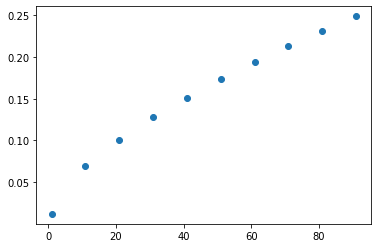

In [ ]:
plt.scatter(x,explained)

In [ ]:
  lsa= TruncatedSVD(n_components=15, random_state=42).fit(text)
  lsa_text = lsa.transform(text)

  lsa_group = [np.argmax(lsa_i) for lsa_i in lsa_text]

In [ ]:
freq = []
n = 0
for i in range(15):
  n = 0
  for j in lsa_group:
    if i == j:
      n = n + 1
  freq.append(n)

<BarContainer object of 15 artists>

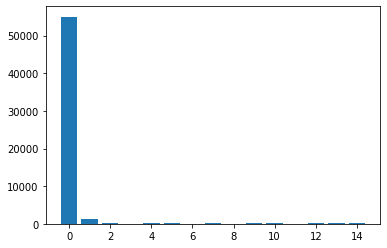

In [ ]:
plt.bar(range(len(freq)),freq)

In [ ]:
# Es un resultado regular, pero el mejor hasta ahora
silhouette_score(text,lsa_group)

0.017642958880505103

## MiniBatchKmeans

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters


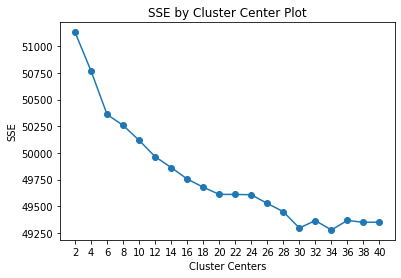

In [ ]:
# función para encontrar la mejor k para MiniBatchK significa
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 40)

In [ ]:
# Encontramos los clusters usando MiniBatchKmeans

# Segun la grafica mostrada 30 clusters parece un buen valor
n_clusters = 30

# Entrenamos el modelo
minibatch = MiniBatchKMeans(n_clusters=n_clusters, batch_size=2048, random_state=20)
minibatch.fit(text)
clusters = minibatch.predict(text)
#clusters = minibatch.fit_predict(text)
print('Clusters: ' + str(clusters))

Clusters: [ 7 16  4 ... 22  1 12]


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(text,clusters)

-0.00023656554020696732

## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
modelo_dbs = DBSCAN(eps=0.7, min_samples=75)
labs = modelo_dbs.fit_predict(text)
print('Silhouette: ', silhouette_score(text, labs))

Silhouette:  -0.24873674847155758


[[-0.14681163  0.03042239]
 [-0.09283595 -0.0818805 ]
 [ 0.12687185  0.04483584]
 ...
 [-0.09549722 -0.01879672]
 [-0.04528022 -0.12731906]
 [ 0.06615153 -0.01776293]]


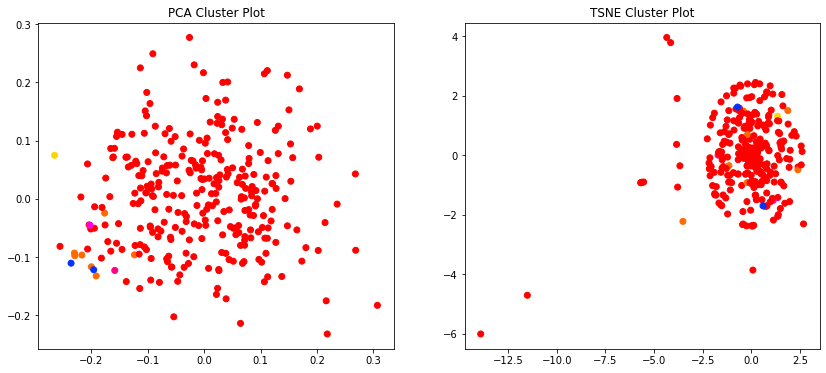

In [ ]:
# Trazando el reducion dimensional pca y tsne
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(data)
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
    print(pca)

plot_tsne_pca(text, np.array(lsa_group))


In [ ]:
# palabras clave principales de cada clúster
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, TFIDF.get_feature_names(), 10)


Cluster 0
looking,really,life,guy,going,family,fun,laugh,smart,funny

Cluster 1
going,show,new,book,anything,life,rock,family,hip,hop

Cluster 2
want,also,get,new,really,work,book,family,life,dog

Cluster 3
school,book,work,get,also,life,one,really,year,wa

Cluster 4
going,working,anything,also,new,family,enjoy,life,book,etc

Cluster 5
know,partner,want,open,man,someone,looking,woman,relationship,life

Cluster 6
one,men,park,rock,life,anything,dead,black,book,show

Cluster 7
want,show,get,computer,really,also,book,playing,video,game

Cluster 8
work,fun,school,life,get,guy,family,going,back,laid

Cluster 9
way,also,want,get,make,really,life,know,think,one

Cluster 10
anything,think,much,get,favorite,book,lot,pretty,really,also

Cluster 11
living,hair,work,school,coffee,book,family,eye,want,working

Cluster 12
go,anything,new,life,think,lot,get,know,want,really

Cluster 13
go,going,want,really,lol,get,life,know,dont,im

Cluster 14
book,okcupid,want,online,gym,working,family,work,iphone,

In [ ]:
# WordCloud de cada clúster
from wordcloud import WordCloud

result={'cluster':labels, 'corpus':corpus}
result=pd.DataFrame(result)
for k in range(0, n_clusters):
   s=result[result.cluster==k]
   text=s['corpus'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   titles=corpus_cl[corpus_cl.cluster==k]['title']         
   #print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

## Reconstruimos la columna essay

In [ ]:
# agregar el clúster al marco de datos
lsa_group_array= np.array(lsa_group).astype(np.int).reshape(-1,1) # Tomamos los valores de lsa que eran los mejores
index = np.array(df_proc['index_essay']).ravel()

In [ ]:
df.loc[index,"essay_completo"] = lsa_group_array

In [ ]:
df.loc[df['essay_completo'].isna(),'essay_completo'] = -1

In [ ]:
df = create_OneHot(df,["essay_completo"])

Procesando columna essay_completo ...
	Numero de categorias unicas: 16
	Categorias unicas: [ 0. 11. -1.  7.  2.  1.  3. 13.  9. 12.  8.  4. 14. 10.  5.  6.]
	Columnas con one_hot: ['essay_completo_-1.0', 'essay_completo_0.0', 'essay_completo_1.0', 'essay_completo_2.0', 'essay_completo_3.0', 'essay_completo_4.0', 'essay_completo_5.0', 'essay_completo_6.0', 'essay_completo_7.0', 'essay_completo_8.0', 'essay_completo_9.0', 'essay_completo_10.0', 'essay_completo_11.0', 'essay_completo_12.0', 'essay_completo_13.0', 'essay_completo_14.0']

Columnas procesadas correctamente: ['essay_completo']
No se han procesado las siguientes columnas: []


In [ ]:
# Eliminamos las columnas de los essays separados
df = df.drop(essays, axis=1)

In [ ]:
df.head(1)

,age,sex,drinks,height,income,last_online,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,education_graduated from law school,education_graduated from masters program,education_graduated from med school,education_graduated from ph.d program,education_graduated from space camp,education_graduated from two-year college,education_high school,education_law school,education_masters program,education_med school,education_ph.d program,education_space camp,education_two-year college,education_working on college/university,education_working on high school,education_working on law school,education_working on masters program,education_working on med school,education_working on ph.d program,education_working on space camp,education_working on two-year college,drugs,asian,...,sign_libra and it matters a lot,sign_libra and it&rsquo;s fun to think about,sign_libra but it doesn&rsquo;t matter,sign_pisces,sign_pisces and it matters a lot,sign_pisces and it&rsquo;s fun to think about,sign_pisces but it doesn&rsquo;t matter,sign_sagittarius,sign_sagittarius and it matters a lot,sign_sagittarius and it&rsquo;s fun to think about,sign_sagittarius but it doesn&rsquo;t matter,sign_scorpio,sign_scorpio and it matters a lot,sign_scorpio and it&rsquo;s fun to think about,sign_scorpio but it doesn&rsquo;t matter,sign_taurus,sign_taurus and it matters a lot,sign_taurus and it&rsquo;s fun to think about,sign_taurus but it doesn&rsquo;t matter,sign_unknown,sign_virgo,sign_virgo and it matters a lot,sign_virgo and it&rsquo;s fun to think about,sign_virgo but it doesn&rsquo;t matter,essay_completo_-1.0,essay_completo_0.0,essay_completo_1.0,essay_completo_2.0,essay_completo_3.0,essay_completo_4.0,essay_completo_5.0,essay_completo_6.0,essay_completo_7.0,essay_completo_8.0,essay_completo_9.0,essay_completo_10.0,essay_completo_11.0,essay_completo_12.0,essay_completo_13.0,essay_completo_14.0
0,0.043478,m,socially,0.787234,0.0,0.991892,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print("Numero de Nan:",df["drinks"].isna().sum())
df.loc[df['drinks'].isnull(), 'drinks'] = 'unknown'

Numero de Nan: 2985


In [ ]:
df = create_OneHot(df,["ethnicity","sex","drinks"])

Procesando columna ethnicity ...
	La columna ethnicity no forma parte del dataframe o ya fue procesada
Procesando columna sex ...
	Numero de categorias unicas: 2
	Categorias unicas: ['m' 'f']
	Columnas con one_hot: ['sex_f', 'sex_m']
Procesando columna drinks ...
	Numero de categorias unicas: 7
	Categorias unicas: ['socially' 'often' 'not at all' 'rarely' 'unknown' 'very often'
 'desperately']
	Columnas con one_hot: ['drinks_desperately', 'drinks_not at all', 'drinks_often', 'drinks_rarely', 'drinks_socially', 'drinks_unknown', 'drinks_very often']

Columnas procesadas correctamente: ['sex', 'drinks']
No se han procesado las siguientes columnas: ['ethnicity']


In [ ]:
df.to_csv('preprocessed_okcupid_profiles.csv')

In [ ]:
df_preprocessed = pd.read_csv('preprocessed_okcupid_profiles.csv', index_col=[0])

In [ ]:
df_preprocessed.shape

(59946, 459)

# Cálculo de compatibilidad

## Haciendo uso de reducción dimensional con autoencoders

In [ ]:
df_preprocessed = df_preprocessed.drop(['sex', 'drinks', 'drugs', 'ethnicity', 'religion', 'sign', 'height'], axis=1)

In [ ]:
df_preprocessed.head(5)

,age,income,last_online,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,education_graduated from law school,education_graduated from masters program,education_graduated from med school,education_graduated from ph.d program,education_graduated from space camp,education_graduated from two-year college,education_high school,education_law school,education_masters program,education_med school,education_ph.d program,education_space camp,education_two-year college,education_working on college/university,education_working on high school,education_working on law school,education_working on masters program,education_working on med school,education_working on ph.d program,education_working on space camp,education_working on two-year college,city_alameda,city_albany,city_amsterdam,city_arcadia,city_asheville,...,job_computer / hardware / software,job_construction / craftsmanship,job_education / academia,job_entertainment / media,job_executive / management,job_hospitality / travel,job_law / legal services,job_medicine / health,job_military,job_other,job_political / government,job_rather not say,job_retired,job_sales / marketing / biz dev,job_science / tech / engineering,job_student,job_transportation,job_unemployed,smokes_no,smokes_sometimes,smokes_trying to quit,smokes_unknown,smokes_when drinking,smokes_yes,essay_completo_-1.0,essay_completo_0.0,essay_completo_1.0,essay_completo_2.0,essay_completo_3.0,essay_completo_4.0,essay_completo_5.0,essay_completo_6.0,essay_completo_7.0,essay_completo_8.0,essay_completo_9.0,essay_completo_10.0,essay_completo_11.0,essay_completo_12.0,essay_completo_13.0,essay_completo_14.0
0,0.043478,0.000000,0.991892,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.184783,0.080001,0.994595,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.217391,0.000000,0.989189,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.054348,0.020001,0.991892,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.119565,0.000000,0.989189,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Input, LeakyReLU
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, losses
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.merge import concatenate

import numpy as np

### Creación del modelo

In [ ]:
def create_autoencoder(X):
    input_encoder = Input(shape=(X.shape[1],), name='encoder_input') # La dimensión de la entrada son todas las columnas del dataset

    x = Dense(X.shape[1])(input_encoder) # Primera capa densa del encoder con tantas neuronas como entradas
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)

    x = Dense(256)(input_encoder) # Segunda capa densa del encoder con 256 neuronas
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    x = Dense(64)(x) # Segunda capa densa del encoder con 64 neuronas
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    x = Dense(10)(x) # Tercera capa densa del encoder con 10 neuronas que corresponden a la representación de cada persona
    output_encoder = LeakyReLU(alpha=0.2, name='encoder_output')(x)

    input_decoder = Dense(64, name='decoder_input')(output_encoder) # Primera capa del decoder densa con 64 neuronas
    x = LeakyReLU(alpha=0.2)(input_decoder)
    x = Dropout(0.4)(x)

    x = Dense(256)(x) # Segunda capa densa del decoder con 256 neuronas
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)

    output_decoder = Dense(X.shape[1], activation='relu', name='decoder_output')(x)

    autoencoder = Model(input_encoder, output_decoder)
    encoder = Model(input_encoder, output_encoder)

    return encoder, autoencoder

In [ ]:
X = df_preprocessed

encoder, autoencoder = create_autoencoder(X)

### Ploteo de la arquitectura

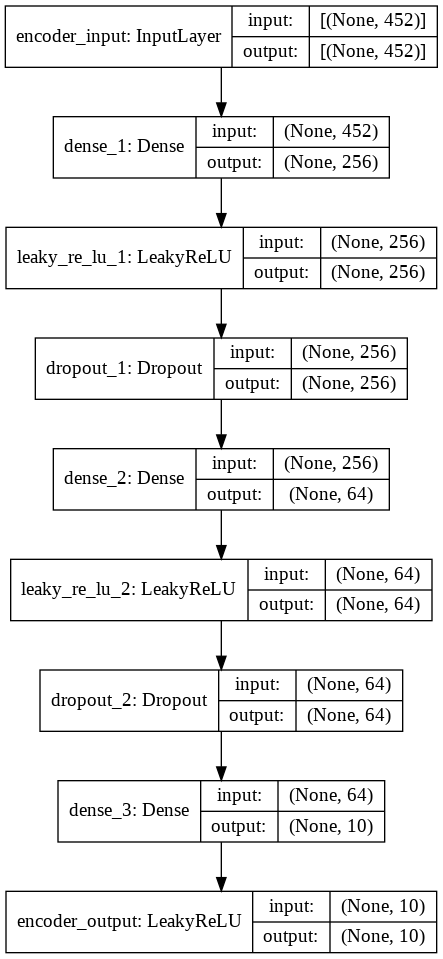

In [ ]:
plot_model(encoder, show_layer_names=True, show_shapes=True)

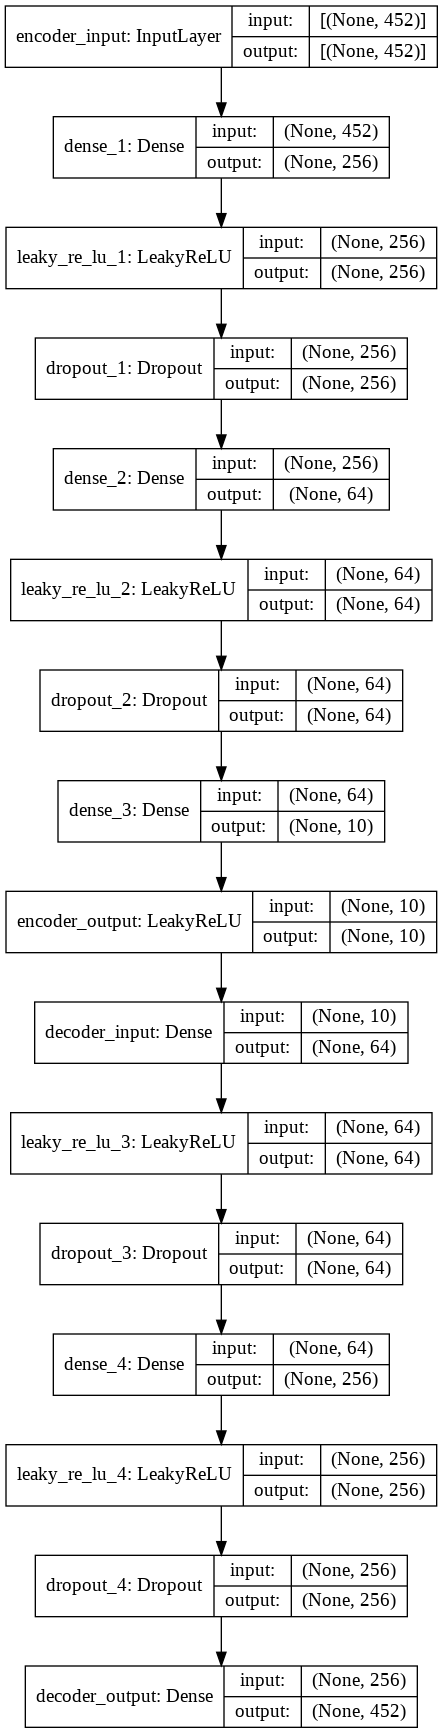

In [ ]:
plot_model(autoencoder, show_layer_names=True, show_shapes=True)

### Entrenamiento del modelo

In [ ]:
def plot_train_val(history):
    plt.rcParams['figure.figsize'] = [15, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    
    ax1.plot(history.history['loss'], label='loss (train)')
    ax1.set_title('Loss')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax2.plot(history.history['mae'], label='mae (train)')
    ax2.set_title('MAE')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax1.grid()
    ax2.grid()
    plt.plot()

Epoch 1/10
235/235 [==============================] - 4s 12ms/step - loss: 0.0195 - mae: 0.0319
Epoch 2/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0149 - mae: 0.0256
Epoch 3/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0137 - mae: 0.0245
Epoch 4/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0129 - mae: 0.0234
Epoch 5/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0124 - mae: 0.0227
Epoch 6/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0120 - mae: 0.0222
Epoch 7/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0116 - mae: 0.0217
Epoch 8/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0112 - mae: 0.0212
Epoch 9/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0110 - mae: 0.0208
Epoch 10/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0108 - mae: 0.0206


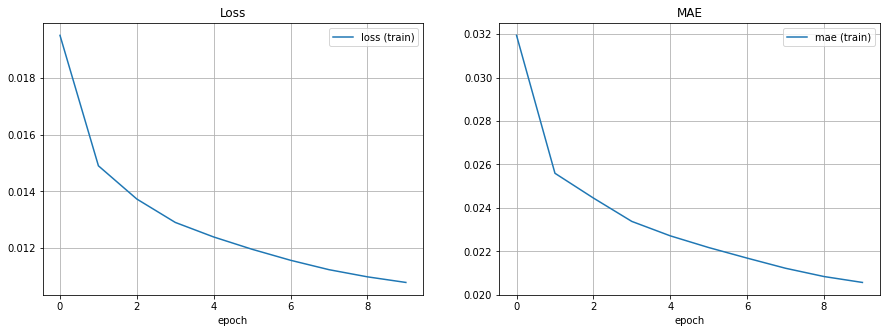

In [ ]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    autoencoder.compile(
        loss='mse', 
        optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['mae'])
    history = autoencoder.fit(X, X,
                        epochs=10, batch_size=256, verbose=1)
plot_train_val(history)

## Predicción

Se predicen las 10 características que resumen a cada individuo haciendo uso del predict del encoder. De esta manera se sucede la reducción dimensional

In [ ]:
encoder_predictions = encoder.predict(X)

In [ ]:
encoder_predictions.shape

(59946, 10)

In [ ]:
encoder_predictions[2]

array([ 0.43083876,  0.00285056, -0.05781983, -0.04410477,  0.65606123,
        0.01915092, -0.0135607 ,  0.09652086,  0.5747603 ,  0.28516227],
      dtype=float32)

Para saber si dos personas son compatibles basta con calcular como de alejadas estan sus representaciones de menor dimensión. A menor número significará que ambos perfiles son más similares y que por lo tanto se parecen más.

Para poner un ejemplo vamos a calcular la lista de compatibilidades de un usuario (el del índice 15) con el resto.

In [ ]:
from scipy.spatial import distance

In [ ]:
index_love_searcher = 15
love_searcher = encoder_predictions[index_love_searcher]
love_finded = None
love_finded_index = None
distance_min = 99999999

for index, candidate in enumerate(encoder_predictions):
    if index != index_love_searcher:
        if index % 10000 == 0:
            print('Calculados ', index, ' candidatos')

        distance_candidate = distance.euclidean(love_searcher, candidate)
        if distance_candidate < distance_min:
            distance_min = distance_candidate
            love_finded = candidate
            love_finded_index = index

print('*'*20)
print(f'La persona de máxima compatibilidad del usuario con índice {index_love_searcher} es el usuario con índice {love_finded_index}')
print('-'*20)
print('Resumen del buscador del amor: ', love_searcher)
print('Resumen del amor encontrado: ', love_finded)
print('\nDistancia entre ambos: ', distance_min)

Calculados  0  candidatos
Calculados  10000  candidatos
Calculados  20000  candidatos
Calculados  30000  candidatos
Calculados  40000  candidatos
Calculados  50000  candidatos
********************
La persona de máxima compatibilidad del usuario con índice 15 es el usuario con índice 28758
--------------------
Resumen del buscador del amor:  [ 0.7829007   0.46746618  0.4972067   0.5592938   0.04558151 -0.00564403
 -0.03975921  0.5390042  -0.03464345  0.2992532 ]
Resumen del amor encontrado:  [ 0.78815484  0.47496903  0.50304615  0.56673014  0.04135182 -0.00528153
 -0.04731233  0.55805176 -0.04017927  0.3061946 ]

Distancia entre ambos:  0.026267973706126213


In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
df_preprocessed.iloc[index_love_searcher, :].to_frame()

,15
age,0.228261
income,0.000000
last_online,0.994595
education_college/university,0.000000
education_dropped out of college/university,0.000000
education_dropped out of high school,0.000000
education_dropped out of law school,0.000000
education_dropped out of masters program,0.000000
education_dropped out of med school,0.000000
education_dropped out of ph.d program,0.000000


In [ ]:
df_preprocessed.iloc[love_finded_index, :].to_frame()

,28758
age,0.119565
income,0.000000
last_online,0.997297
education_college/university,0.000000
education_dropped out of college/university,0.000000
education_dropped out of high school,0.000000
education_dropped out of law school,0.000000
education_dropped out of masters program,0.000000
education_dropped out of med school,0.000000
education_dropped out of ph.d program,0.000000


Para filtrar a los individuos por orientación sexual posteriormente con una sencilla función podríamos descartar, en orden decreciente de grado de compatibilidad, los que no sean compatibles, por ejemplo hombre hetero con hombre gay o bisexual